In [4]:
import json

# Membaca file JSON
with open('encrypted_api_key.json', 'r') as json_file:
    data = json.load(json_file)

# Mendapatkan kunci terenkripsi
encrypted_api_key = data["encrypted_key"]

# Fungsi untuk mendekripsi kunci
def decrypt_key(encrypted_key, keyword):
    decrypted_key = ""
    keyword_index = 0

    for char in encrypted_key:
        if char.isalpha():
            # Menghitung offset ASCII berdasarkan huruf besar atau kecil
            ascii_offset = ord('A') if char.isupper() else ord('a')

            # Mendapatkan karakter kunci untuk dekripsi berdasarkan indeks kata kunci
            key_char = keyword[keyword_index % len(keyword)]

            # Menghitung pergeseran berdasarkan huruf besar dari karakter kunci
            key_offset = ord(key_char.upper()) - ord('A')

            # Melakukan dekripsi dengan pergeseran sesuai karakter kunci
            decrypted_char = chr((ord(char) - ascii_offset - key_offset) % 26 + ascii_offset)
            decrypted_key += decrypted_char

            # Mengupdate indeks kata kunci
            keyword_index += 1
        else:
            decrypted_key += char

    return decrypted_key

# Keyword untuk dekripsi (sama dengan saat mengenkripsi)
keyword = "KUNCI_API_KEY"

# Mendekripsi kunci JSON API
decrypted_api_key = decrypt_key(encrypted_api_key, keyword)

In [5]:
import pandas as pd

# Membaca file CSV
df = pd.read_csv('dataset.csv')
df.head(10)


,url,status
0,https://pacitankab.sipbos.kemendagri.go.id/ind...,Legitimate
1,https://registry.gov.in/login.php,Legitimate
2,https://aplikasi-indonesia.com/kamusbahasaingg...,Legitimate
3,https://dev-garena-free-fire-official.pantheon...,Phishing
4,http://xn--ingenieurbro-kps-szb.de/,Phishing
5,https://riaucybersolution.net/clientarea.php,Legitimate
6,http://1636365.com/assets/40vue.503ff477.js/as...,Phishing
7,https://www.linkedin.com/,Legitimate
8,https://www.airbus.com/en/products-services/co...,Legitimate
9,https://eventtopupfreeceeee.000webhostapp.com/...,Phishing


In [6]:
# Menampilkan statistik deskriptif transpose
df.describe().T

,count,unique,top,freq
url,626,626,https://pacitankab.sipbos.kemendagri.go.id/ind...,1
status,626,2,Legitimate,313


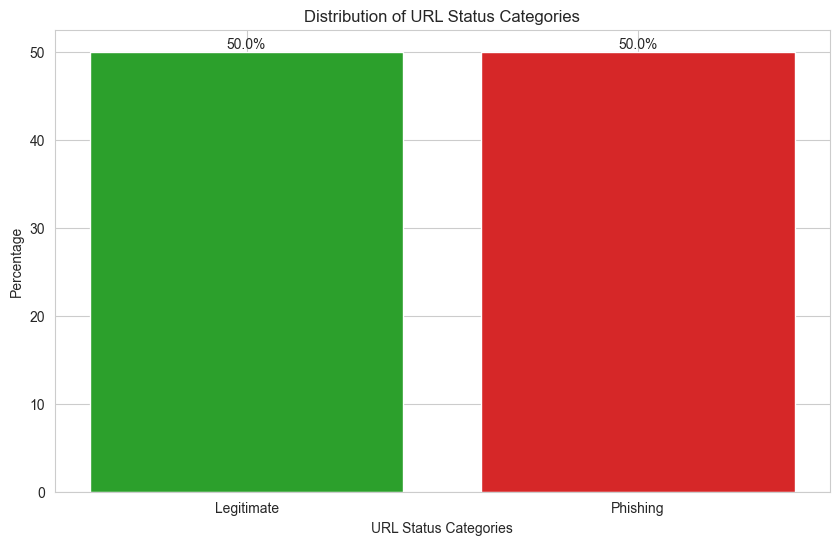

In [7]:
import matplotlib.pyplot as plt

# Menghitung jumlah URL dalam setiap kategori
status_counts = df['status'].value_counts()

# Menghitung persentase masing-masing kategori
total = status_counts.sum()
percentages = status_counts / total * 100

# Menentukan warna untuk setiap bagian grafik batang
colors = ['#2ca02c', '#d62728']

# Membuat plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(status_counts.index, percentages, color=colors)

# Menambahkan label pada sumbu x dan y
ax.set_xlabel('URL Status Categories')
ax.set_ylabel('Percentage')

# Menambahkan label persentase pada setiap batang
for i, p in enumerate(ax.patches):
    percentage = f'{percentages.values[i]:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Menambahkan judul
ax.set_title('Distribution of URL Status Categories')

plt.show()


# Mendefinisikan fitur ekstraksi dan melakukan ekstraksi dari fitur fitur

In [ ]:
from urllib.parse import urlparse
import re
import openai
import whois
import time

# Fungsi untuk menghitung panjang domain
def length_domain(url):
    global result_length
    parsed_url = urlparse(url)  # Menguraikan URL
    domain = parsed_url.netloc  # Mengambil bagian netloc (domain)
    domain_parts = domain.split('.')  # Memisahkan domain berdasarkan titik

    # Memeriksa jumlah bagian domain
    if len(domain_parts) >= 3:
        # Jika dua bagian terakhir dari domain memiliki panjang 2, ambil tiga bagian terakhir sebagai domain utama
        if len(domain_parts[-2]) == 2 and len(domain_parts[-1]) == 2:
            main_domain = '.'.join(domain_parts[-3:])
        else:  # Jika tidak, ambil dua bagian terakhir sebagai domain utama
            main_domain = '.'.join(domain_parts[-2:])
    else:  # Jika jumlah bagian domain kurang dari 3, ambil semua bagian sebagai domain utama
        main_domain = '.'.join(domain_parts)

    length = len(main_domain)  # Menghitung panjang domain utama
    if length <= 11:  # Jika panjang domain utama kurang dari atau sama dengan 11, return 1
        result_length = 1
    elif length > 11:  # Jika panjang domain utama lebih dari 11, return -1
        result_length = -1

    return result_length

# Fungsi untuk memeriksa keberadaan tanda hubung (-) dalam domain
def dashes(url):
    parsed_url = urlparse(url)  # Menguraikan URL
    domain = parsed_url.netloc  # Mengambil bagian netloc (domain)
    domain_parts = domain.split('.')  # Memisahkan domain berdasarkan titik

    for part in domain_parts:  # Untuk setiap bagian domain
        if '-' in part:  # Jika terdapat tanda hubung (-), return -1
            return -1

    return 1  # Jika tidak ada tanda hubung (-), return 1

# Fungsi untuk memeriksa penggunaan HTTPS
def check_ssl(url):
    parsed_url = urlparse(url)  # Menguraikan URL
    scheme = parsed_url.scheme  # Mengambil skema (HTTP atau HTTPS)

    if scheme == 'https':  # Jika skema adalah HTTPS, return 1
        return 1
    else:  # Jika skema bukan HTTPS, return -1
        return -1

# Fungsi untuk memeriksa keberadaan simbol @ dalam URL
def check_at(url):
    if '@' in url:  # Jika simbol @ ada dalam URL, return -1
        return -1
    else:  # Jika simbol @ tidak ada dalam URL, return 1
        return 1

# Fungsi untuk memeriksa jumlah path dalam URL
def check_path(url):
    parsed_url = urlparse(url)  # Menguraikan URL
    path = parsed_url.path  # Mengambil bagian path

    jumlah_path = path.count('/') - 1  # Menghitung jumlah path

    if jumlah_path <= 3:  # Jika jumlah path kurang dari atau sama dengan 3, return 1
        return 1
    else:  # Jika jumlah path lebih dari 3, return -1
        return -1

# Fungsi untuk memeriksa apakah domain adalah IP
def check_ip(url):
    domain = re.findall(r'^(?:https?:\/\/)?(?:[^@\n]+@)?(?:www\.)?([^:\/\n]+)', url)  # Mengekstrak domain dari URL

    if domain:  # Jika domain ditemukan
        domain = domain[0]
        if re.match(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$', domain):  # Jika domain adalah IP, return -1
            return -1
    return 1  # Jika domain bukan IP, return 1

# Fungsi untuk memeriksa apakah domain berisi angka
def check_domain_numeric(url):
    match = re.search(r'(?<=://)[\w\.-]+', url)  # Mencari domain dalam URL
    if match:  # Jika domain ditemukan
        domain = match.group(0)
        has_number = any(char.isdigit() for char in domain)  # Memeriksa apakah domain berisi angka
        if has_number:  # Jika domain berisi angka, return -1
            return -1
    return 1  # Jika domain tidak berisi angka, return 1

# Fungsi untuk memeriksa penggunaan URL pendek
def use_short_url(url):
    url_shorteners = ['bit.ly', 'goo.gl', 't.ly', 'tinyurl.com', 'shorturl.at', 'rb.gy', 'cutt.ly', 's.id', 'is.gd', 'tiny.cc']
    for shortener in url_shorteners:  # Untuk setiap penyedia URL pendek
        if shortener in url:  # Jika penyedia URL pendek ada dalam URL, return -1
            return -1
    return 1  # Jika tidak ada penyedia URL pendek dalam URL, return 1

# Fungsi untuk menghitung jumlah slash tunggal dalam URL
def count_single_slash(url):
    single_slash_count = url.count('/') - url.count('//')  # Menghitung jumlah slash tunggal (mengurangi jumlah slash ganda)
    if single_slash_count > 4:  # Jika jumlah slash tunggal lebih dari 4, return -1
        return -1
    else:  # Jika jumlah slash tunggal kurang dari atau sama dengan 4, return 1
        return 1

# Fungsi untuk menghitung jumlah titik dalam URL
def count_dots(url):
    dot_count = url.count('.')  # Menghitung jumlah titik
    if dot_count > 5:  # Jika jumlah titik lebih dari 5, return -1
        return -1
    else:  # Jika jumlah titik kurang dari atau sama dengan 5, return 1
        return 1

# Fungsi untuk memeriksa panjang URL
def length_url(url):
    if len(url) > 80:  # Jika panjang URL lebih dari 80, return -1
        return -1
    else:  # Jika panjang URL kurang dari atau sama dengan 80, return 1
        return 1

# Fungsi untuk menggunakan OpenAI untuk memeriksa URL
def openai_model_text_davinci_003(url):
    while True:
        try:
            openai.api_key = decrypted_api_key  # Mengatur kunci API
            command = f"Periksa URL ini merupakan phishing atau tidak. Jika phishing berikan nilai output -1, dan jika tidak phishing berikan nilai 1. Output hanya berupa angka 1 dan -1 '{url}'"

            response = openai.Completion.create(
                model="text-davinci-003",  # Menggunakan model text-davinci-003
                prompt=command,  # Mengatur perintah
                temperature=1,  # Mengatur suhu
                max_tokens=120,  # Mengatur jumlah token maksimum
                top_p=1,  # Mengatur nilai top p
                frequency_penalty=0,  # Mengatur hukuman frekuensi
                presence_penalty=0  # Mengatur hukuman keberadaan
            )
            result = response.choices[0].text.strip()  # Mengambil hasil
            return result  # Mengembalikan hasil
        except Exception as e:
            print("Terjadi kesalahan:", str(e))
            print("Akan mencoba kembali setelah 5 detik...")
            time.sleep(5)  # Jeda selama 5 detik sebelum mencoba lagi

def openai_model_gpt_3_5_turbo(url):
    while True:
        try:
            openai.api_key = decrypted_api_key  # Mengatur kunci API
            command = f"Jika phishing, berikan nilai output -1. Jika tidak phishing, berikan nilai output 1. Output hanya boleh berupa angka 1 dan -1 tanpa deskripsi penjelasan. '{url}'"

            completion = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "user", "content": command}
                ]
            )
            result = completion.choices[0].message['content']  # Mengambil hasil
            if result == '-1':
                return -1
            elif result == '1':
                return 1
        except Exception as e:
            print("Terjadi kesalahan:", str(e))
            print("Akan mencoba kembali setelah 5 detik...")
            time.sleep(5)  # Jeda selama 5 detik sebelum mencoba lagi

# Fungsi untuk memeriksa registrasi whois
def check_whois(url):
    try:
        domain = whois.whois(url)  # Mendapatkan informasi whois domain
        if domain.status:  # Jika domain memiliki status, return 1
            return 1
        else:  # Jika domain tidak memiliki status, return -1
            return -1
    except Exception as e:  # Jika terjadi kesalahan, mencetak kesalahan dan return -1
        print("Error:", e)
        return -1

# Memproses data dalam DataFrame
df['url'] = df['url'].astype(str)  # Mengubah kolom url menjadi string
df['status'] = df['status'].apply(lambda x: 1 if x == 'Aman' else -1)  # Mengubah status 'Aman' menjadi 1 dan selain itu menjadi -1

# Menerapkan setiap fungsi ke kolom url dan menyimpan hasilnya dalam kolom baru
df['length_domain'] = df['url'].apply(length_domain)
df['subdomain/domain_dashes'] = df['url'].apply(dashes)
df['ssl/https'] = df['url'].apply(check_ssl)
df['at_@'] = df['url'].apply(check_at)
df['path'] = df['url'].apply(check_path)
df['use_ip'] = df['url'].apply(check_ip)
df['domain_numeric'] = df['url'].apply(check_domain_numeric)
df['short_url'] = df['url'].apply(use_short_url)
df['single_slash'] = df['url'].apply(count_single_slash)
df['dot'] = df['url'].apply(count_dots)
df['url_length'] = df['url'].apply(length_url)
df['text-davinci-003'] = df['url'].apply(openai_model_text_davinci_003)
df['gpt-3.5-turbo'] = df['url'].apply(openai_model_gpt_3_5_turbo)
df['whois_registration'] = df['url'].apply(check_whois)

In [ ]:
df.head(20)

In [ ]:
# Simpan DataFrame ke dalam file CSV
df.to_csv('Feature_Extraction.csv', index=False)

In [ ]:
import pandas as pd

# Membaca file CSV
df = pd.read_csv('Feature_Extraction.csv')
df.head(547)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Memilih fitur-fitur yang relevan untuk matriks korelasi
features = [
    'length_domain',
    'subdomain/domain_dashes',
    'ssl/https',
    'at_@',
    'path',
    'use_ip',
    'domain_numeric',
    'short_url',
    'single_slash',
    'dot',
    'url_length',
    'text-davinci-003',
    'gpt-3.5-turbo',
    'whois_registration'
]

# Membuat matriks korelasi
correlation_matrix = df[features].corr()

# Membuat heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Feature Correlation')
plt.show()


# Split Data

In [ ]:
from sklearn.model_selection import train_test_split

# Membagi dataframe menjadi fitur dan target
X = df.drop(['url', 'status'], axis=1)  # Fitur adalah semua kolom kecuali url dan status
y = df['status']  # Target adalah kolom status

# Membagi dataset menjadi training set dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pemodelan Training Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Import library yang diperlukan
# pandas digunakan untuk manipulasi dan analisis data
# matplotlib.pyplot digunakan untuk membuat visualisasi grafik
# seaborn digunakan untuk meningkatkan tampilan visualisasi grafik
# confusion_matrix, accuracy_score, precision_score, recall_score, f1_score adalah metrik evaluasi klasifikasi
# svm, RandomForestClassifier, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, MLPClassifier, GaussianNB adalah algoritma klasifikasi yang digunakan

# SVM (Support Vector Machine)
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_f1 = f1_score(y_test, dt_y_pred)

# kNN (k-Nearest Neighbors)
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)
knn_f1 = f1_score(y_test, knn_y_pred)

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_y_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred)
lr_recall = recall_score(y_test, lr_y_pred)
lr_f1 = f1_score(y_test, lr_y_pred)

# Neural Network
nn_model = MLPClassifier()
nn_model.fit(X_train, y_train)
nn_y_pred = nn_model.predict(X_test)
nn_accuracy = accuracy_score(y_test, nn_y_pred)
nn_precision = precision_score(y_test, nn_y_pred)
nn_recall = recall_score(y_test, nn_y_pred)
nn_f1 = f1_score(y_test, nn_y_pred)

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred)
nb_recall = recall_score(y_test, nb_y_pred)
nb_f1 = f1_score(y_test, nb_y_pred)

# Menggunakan algoritma SVM (Support Vector Machine) untuk klasifikasi dengan kernel linear
# Melakukan training model menggunakan data latih (X_train, y_train)
# Melakukan prediksi menggunakan data uji (X_test)
# Menghitung akurasi menggunakan accuracy_score
# Menghitung presisi menggunakan precision_score
# Menghitung recall menggunakan recall_score
# Menghitung F1-score menggunakan f1_score

# Melakukan hal yang sama untuk algoritma lainnya: Random Forest, Decision Tree, k-NN, Logistic Regression, Neural Network, dan Naive Bayes

# Membuat DataFrame untuk menyimpan metrik evaluasi
metrics_df = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Decision Tree', 'k-NN', 'Logistic Regression', 'Neural Network', 'Naive Bayes'],
    'Accuracy': [svm_accuracy, rf_accuracy, dt_accuracy, knn_accuracy, lr_accuracy, nn_accuracy, nb_accuracy],
    'Precision': [svm_precision, rf_precision, dt_precision, knn_precision, lr_precision, nn_precision, nb_precision],
    'Recall': [svm_recall, rf_recall, dt_recall, knn_recall, lr_recall, nn_recall, nb_recall],
    'F1-score': [svm_f1, rf_f1, dt_f1, knn_f1, lr_f1, nn_f1, nb_f1]
})

# Menghitung nilai rata-rata untuk setiap metrik
metrics_df['Mean'] = metrics_df.mean(axis=1)

# Mengurutkan DataFrame berdasarkan nilai rata-rata secara menurun
sorted_metrics_df = metrics_df.sort_values(by='Mean', ascending=False)

# Menghapus kolom 'Mean'
sorted_metrics_df = sorted_metrics_df.drop('Mean', axis=1)

# Menampilkan DataFrame yang telah diurutkan tanpa kolom 'Mean'
sorted_metrics_df.head(7)

In [ ]:
# Confusion Matrix for SVM
# Menghitung confusion matrix untuk model SVM
svm_cm = confusion_matrix(y_test, svm_y_pred)

# Confusion Matrix for Random Forest
# Menghitung confusion matrix untuk model Random Forest
rf_cm = confusion_matrix(y_test, rf_y_pred)

# Confusion Matrix for Decision Tree
# Menghitung confusion matrix untuk model Decision Tree
dt_cm = confusion_matrix(y_test, dt_y_pred)

# Confusion Matrix for kNN
# Menghitung confusion matrix untuk model k-NN
knn_cm = confusion_matrix(y_test, knn_y_pred)

# Confusion Matrix for Logistic Regression
# Menghitung confusion matrix untuk model Logistic Regression
lr_cm = confusion_matrix(y_test, lr_y_pred)

# Confusion Matrix for Neural Network
# Menghitung confusion matrix untuk model Neural Network
nn_cm = confusion_matrix(y_test, nn_y_pred)

# Confusion Matrix for Naive Bayes
# Menghitung confusion matrix untuk model Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_pred)

# Menggabungkan semua confusion matrix
# Menyimpan semua confusion matrix dalam sebuah list
confusion_matrices = [svm_cm, rf_cm, dt_cm, knn_cm, lr_cm, nn_cm, nb_cm]

# Menggabungkan semua akurasi, presisi, recall, dan F1-score
# Menyimpan semua nilai akurasi, presisi, recall, dan F1-score dalam sebuah list
accuracies = [svm_accuracy, rf_accuracy, dt_accuracy, knn_accuracy, lr_accuracy, nn_accuracy, nb_accuracy]
precisions = [svm_precision, rf_precision, dt_precision, knn_precision, lr_precision, nn_precision, nb_precision]
recalls = [svm_recall, rf_recall, dt_recall, knn_recall, lr_recall, nn_recall, nb_recall]
f1_scores = [svm_f1, rf_f1, dt_f1, knn_f1, lr_f1, nn_f1, nb_f1]

# Set color palette
# Menentukan palet warna untuk plot
colors = ['Blues', 'Greens', 'Reds', 'Purples']

# Plotting the confusion matrices
# Membuat plot untuk setiap confusion matrix
plt.figure(figsize=(20, 16))
for i in range(len(confusion_matrices)):
    plt.subplot(4, 7, i+1)
    # Membuat heatmap untuk setiap confusion matrix dengan anotasi dan menggunakan warna yang telah ditentukan
    sns.heatmap(confusion_matrices[i], annot=True, cmap=colors[i%4], fmt="d", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    models = ['SVM', 'Random Forest', 'Decision Tree', 'kNN', 'Logistic Regression', 'Neural Network', 'Naive Bayes']
    plt.title(f'Confusion Matrix - {models[i]}')

# Print the metrics
# Menampilkan metrik evaluasi
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Metrik evaluasi
models = ['SVM', 'Random Forest', 'Decision Tree', 'k-NN', 'Logistic Regression', 'Neural Network', 'Naive Bayes']
accuracy = [svm_accuracy, rf_accuracy, dt_accuracy, knn_accuracy, lr_accuracy, nn_accuracy, nb_accuracy]
precision = [svm_precision, rf_precision, dt_precision, knn_precision, lr_precision, nn_precision, nb_precision]
recall = [svm_recall, rf_recall, dt_recall, knn_recall, lr_recall, nn_recall, nb_recall]
f1 = [svm_f1, rf_f1, dt_f1, knn_f1, lr_f1, nn_f1, nb_f1]

# Mengatur posisi bar
bar_width = 0.2
index = np.arange(len(models))

# Warna bar
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Membuat plot
plt.figure(figsize=(12, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy', color=colors[0])
plt.bar(index + bar_width, precision, bar_width, label='Precision', color=colors[1])
plt.bar(index + (2 * bar_width), recall, bar_width, label='Recall', color=colors[2])
plt.bar(index + (3 * bar_width), f1, bar_width, label='F1-score', color=colors[3])

# Mengatur label sumbu x
plt.xlabel('Models')
plt.ylabel('Scores')
plt.xticks(index + (1.5 * bar_width), models, rotation=45)

# Menambahkan legend dan judul
plt.legend()
plt.title('Comparison of Accuracy, Precision, Recall, and F1-score')

# Menampilkan plot
plt.tight_layout()
plt.show()


In [ ]:
import pickle

# Save model
models = {
    'svm': svm_model,  # Kamus untuk menyimpan model-machine learning dengan kunci sebagai nama model
    'rf': rf_model,
    'dt': dt_model,
    'knn': knn_model,
    'lr': lr_model,
    'nn': nn_model,
    'nb': nb_model
}

for model_name, model in models.items():  # Perulangan untuk setiap model dalam kamus
    with open(f'result_{model_name}_model.pkl', 'wb') as file:  # Membuka file untuk menyimpan model
        pickle.dump(model, file)  # Menyimpan model ke dalam file menggunakan pickle.dump()
        # Model-machine learning disimpan dalam file terpisah dengan format nama yang menggambarkan nama modelnya


In [ ]:
import pandas as pd
import pickle

# Fungsi untuk ekstraksi fitur URL
def extract_features(url):
    features = {'length_domain': length_domain(url), 'subdomain/domain_dashes': dashes(url),
                'ssl/https': check_ssl(url), 'at_@': check_at(url), 'path': check_path(url), 'use_ip': check_ip(url),
                'domain_numeric': check_domain_numeric(url), 'short_url': use_short_url(url),
                'single_slash': count_single_slash(url), 'dot': count_dots(url), 'url_length': length_url(url),
                'text-davinci-003': openai_model_text_davinci_003(url), 'gpt-3.5-turbo': openai_model_gpt_3_5_turbo(url), 'whois_registration': check_whois(url)}

    return pd.DataFrame([features])

# Membaca model dari file pickle
models = {}
model_files = {
    'Support Vector Machine': 'result_svm_model.pkl',
    'Random Forest': 'result_rf_model.pkl',
    'Decision Tree': 'result_dt_model.pkl',
    'k-Nearest Neighbors': 'result_knn_model.pkl',
    'Logistic Regression': 'result_lr_model.pkl',
    'Neural Network': 'result_nn_model.pkl',
    'Naive Bayes': 'result_nb_model.pkl'
}

for model_name, model_file in model_files.items():
    with open(model_file, 'rb') as file:
        model = pickle.load(file)
        models[model_name] = model

# URL yang ingin diprediksi
actual_urls_phishing = [
    "https://businessformetacenter.com/234742354/index.php",
    "https://melly399.github.io/facebookl/",
    "http://salavirtualnetflix.cu.ma/login.php",
    "https://telegarmu.com/"
]

actual_urls_legitimate = [
    "https://web.telegram.org/",
    "https://www.facebook.com/photo/?fbid=2449282261914233&set=pcb.2449283111914148",
    "https://shopee.co.id/Modul-ESP8266-ESP-01-ESP01-Wifi-Serial-Module-ESP-01-i.40647041.2101318868?sp_atk=fe81d7b3-beae-47ca-b70f-5a8d730a1a20&xptdk=fe81d7b3-beae-47ca-b70f-5a8d730a1a20",
    "https://www.youtube.com/watch?v=QLFrEb6yjH8&list=RDQLFrEb6yjH8&start_radio=1"
]

# Ekstraksi fitur untuk URL yang tidak aman
new_features_bad = pd.concat([extract_features(url) for url in actual_urls_phishing])

# Ekstraksi fitur untuk URL yang aman
new_features_good = pd.concat([extract_features(url) for url in actual_urls_legitimate])

# Membuat tabel hasil prediksi
results = []
for model_name, model in models.items():
    # Prediksi untuk URL yang tidak aman
    predictions_phishing = model.predict(new_features_phishing)
    for url, prediction in zip(actual_urls_phishing, predictions_phishing):
        if prediction == 1:
            result = "Legitimate"
        else:
            result = "Phishing"
        results.append({'URL': url, 'Model': model_name, 'Actual': 'Phishing', 'Prediction Result': result})

    # Prediksi untuk URL yang aman
    predictions_legitimate = model.predict(new_features_legitimate)
    for url, prediction in zip(actual_urls_legitimate, predictions_legitimate):
        if prediction == 1:
            result = "Legitimate"
        else:
            result = "Phishing"
        results.append({'URL': url, 'Model': model_name, 'Actual': 'Legitimate', 'Prediction Result': result})

output_table = pd.DataFrame(results)

# Pisahkan output_table berdasarkan Model
grouped = output_table.groupby('Model')

# Membuat DataFrame terpisah untuk setiap model
svm_table = grouped.get_group('Support Vector Machine')
rf_table = grouped.get_group('Random Forest')
dt_table = grouped.get_group('Decision Tree')
knn_table = grouped.get_group('k-Nearest Neighbors')
lr_table = grouped.get_group('Logistic Regression')
nn_table = grouped.get_group('Neural Network')
nb_table = grouped.get_group('Naive Bayes')


In [ ]:
svm_table.head(8)

In [ ]:
rf_table.head(8)

In [ ]:
dt_table.head(8)

In [ ]:
knn_table.head(8)

In [ ]:
lr_table.head(8)

In [ ]:
nn_table.head(8)

In [ ]:
nb_table.head(8)